## Final Project: Habitat Suitability

This notebook begins data preparation on the Earth Analytics Foundations course (Fall semester 2024) final project, habitat suitability. For this analysis I have chosen the Western Larch (*Larix occidentalis*), a deciduous conifer found in the northwestern United States and southwestern Canada. In addition to being deciduous (losing its needles each growing season) it is known for turning golden yellow in the fall. 

In [5]:
import os
import pathlib
import re
import zipfile
from io import BytesIO
from glob import glob
import requests

import earthaccess
import earthpy as et
import numpy as np
import pandas as pd
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
from math import floor, ceil

import xarray as xr
import rioxarray as rxr  #work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
from rasterio.mask import mask
import xrspatial # 
import warnings

### Western Larch Range

Here is a map of the range of the Western larch in the northwestern United States (Montana, Idaho, Oregon, and Washington) and southwestern Canada (British Columbia). 

<a title="Elbert L. Little, Jr., of the U.S. Department of Agriculture, Forest Service, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Larix_occidentalis_range_map_4.png"><img width="512" alt="Larix occidentalis range map in the northwestern United States and southwestern Canada" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Larix_occidentalis_range_map_4.png/512px-Larix_occidentalis_range_map_4.png?20140105205740"></a>

Map credit: Elbert L. Little, Jr., of the U.S. Department of Agriculture, Forest Service, Public domain, via Wikimedia Commons

In [2]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_final'
)
os.makedirs(data_dir, exist_ok=True)

# Define info for USFS NF shapefile download
nfs_url = ("https://data.fs.usda.gov/geodata/edw/"
               "edw_resources/shp/S_USA.AdministrativeForest.zip")

nfs_dir = os.path.join(data_dir, 'usfs_national_forests')
os.makedirs(nfs_dir, exist_ok=True)
nfs_shp_path = os.path.join(nfs_dir, 'S_USA.AdministrativeForest.shp')

# Only download once
if not os.path.exists(nfs_shp_path):
    nfs_gdf = gpd.read_file(nfs_url)
    nfs_gdf.to_file(nfs_shp_path)

if os.path.exists(nfs_shp_path):
    nfs_gdf = gpd.read_file(nfs_shp_path)
#nfs_gdf.head()

# Unzip spatial data
#with zipfile.ZipFile(S_USA.AdministrativeForest.zip) as download_zip:
#    download_zip.extractall(path=nfs_dir)



In [3]:
# Subset to Willamette and Umatilla NFs
nfs2_gdf = nfs_gdf[nfs_gdf['FORESTNAME'].isin(['Umatilla National Forest', 'Payette National Forest'])]
# Check the data
nfs2_gdf

# Also get each as a separate geodataframe for some processing
uma_gdf = nfs_gdf[nfs_gdf['FORESTNAME'] == 'Umatilla National Forest']
pay_gdf = nfs_gdf[nfs_gdf['FORESTNAME'] == 'Payette National Forest']

In [6]:
# Log into EarthAccess for Shuttle Radar Topography Mission (SRTM) downloads
earthaccess.login(strategy="interactive", persist=True)
srtm_search = earthaccess.search_datasets(keyword='SRTM DEM')
#srtm_search

In [7]:
# Set up directory for SRTM elevation model data
srtm_dir = os.path.join(data_dir, 'srtm')
os.makedirs(srtm_dir, exist_ok=True)
srtm_shp_path = os.path.join(srtm_dir, ' .shp')

In [8]:
#Get results separately by forest
pay_results = earthaccess.search_data(
    short_name="SRTMGL1",
    bounding_box=tuple(pay_gdf.total_bounds),
)
pay_results

[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -117.00027778, 'EastBoundingCoordinate': -115.99972222, 'NorthBoundingCoordinate': 46.00027778, 'SouthBoundingCoordinate': 44.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
 Size(MB): 15.2257
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N45W117.SRTMGL1.hgt/N45W117.SRTMGL1.hgt.zip'],
 Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -117.00027778, 'EastBoundingCoordinate': -115.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTim

In [15]:
#will_results = earthaccess.search_data(
#    short_name="SRTMGL1",
#    bounding_box=tuple(will_gdf.total_bounds),
#)
#will_results
# 4 

In [9]:
uma_results = earthaccess.search_data(
    short_name="SRTMGL1",
    bounding_box=tuple(uma_gdf.total_bounds),
)
uma_results
#6 

[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -120.00027778, 'EastBoundingCoordinate': -118.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
 Size(MB): 12.1273
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N44W120.SRTMGL1.hgt/N44W120.SRTMGL1.hgt.zip'],
 Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -118.00027778, 'EastBoundingCoordinate': -116.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTim

In [10]:
# Define a search for the SRTM zipped results
srtm_path = os.path.join(srtm_dir, '*.hgt.zip')

# Download the search results if not already done
if not glob(srtm_path):
    for result in srtm_results:
        earthaccess.download(result, srtm_dir)


In [11]:
# Define a pattern for the unzipped tile images
srtm_pattern = os.path.join(srtm_dir, '*.hgt')

# Now unzip all the dlownload files 
if not glob(srtm_pattern):
    for srtm_path in glob(srtm_pattern):
        #print(srtm_path)
        with zipfile.ZipFile(srtm_path) as download_zip:
            download_zip.extractall(path=srtm_dir)

In [39]:
# Add a small buffer of 0.25 degree around the polygons for later operations
buffer = 0.25
gdfs = [uma_gdf, pay_gdf]
#names = ['Umatilla', 'Payette']
sites = dict(
{'gdf': [pay_gdf, uma_gdf],
 'name': ['Payette NF', 'Umatilla NF']
})
sites

{'gdf': [        ADMINFORES REGION FORESTNUMB FORESTORGC               FORESTNAME  \
  58  99041200010343     04         12       0412  Payette National Forest   
  
        GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
  58  2407296.569    1.113418  11.686712   
  
                                               geometry  
  58  MULTIPOLYGON (((-115.21399 45.56972, -115.2137...  ,
          ADMINFORES REGION FORESTNUMB FORESTORGC                FORESTNAME  \
  92  99061400010343     06         14       0614  Umatilla National Forest   
  
        GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
  92  1498094.353     0.69758  15.051197   
  
                                               geometry  
  92  MULTIPOLYGON (((-118.00972 45.61629, -118.0097...  ],
 'name': ['Payette NF', 'Umatilla NF']}

In [16]:
buff_bounds_dict = {}
#for gdf, (index, row) in gdfs, enumerate(sites.iterrows()):
#for gdf in gdfs:
    #buff_bounds_dict[name] = row['name']
#    bounds = tuple((gdf.to_crs(4326).total_bounds))
    #print(bounds)
#    xmin, ymin, xmax, ymax = bounds
#    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
#    print(bounds_buffer)
    #buff_bounds_dict[site_name] = names[i]
    #OR bounds[gdf.NAME] = do_something(gdf)
#    buff_bounds_dict[bounds_buffer] = bounds_buffer
    
#buff_bounds_dict[bounds_buffer]

In [ ]:
# This is just example code - can ignore now
dat = {'Name': ['Alice', 'Bob', 'Charlie'], 'Age': [25, 30, 35]}
df = pd.DataFrame(dat)

# Using enumerate to get the iteration number
for i, (index, row) in enumerate(df.iterrows()):
    print(f"Iteration {i}: Index {index}, Name {row['Name']}, Age {row['Age']}")

Iteration 0: Index 0, Name Alice, Age 25
Iteration 1: Index 1, Name Bob, Age 30
Iteration 2: Index 2, Name Charlie, Age 35


In [ ]:
ub = uma_gdf.total_bounds
ub
xmin, ymin, xmax, ymax = ub
ub_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
ub_buffer

array([-119.95978061,   44.70581178, -117.24830028,   46.47555163])

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

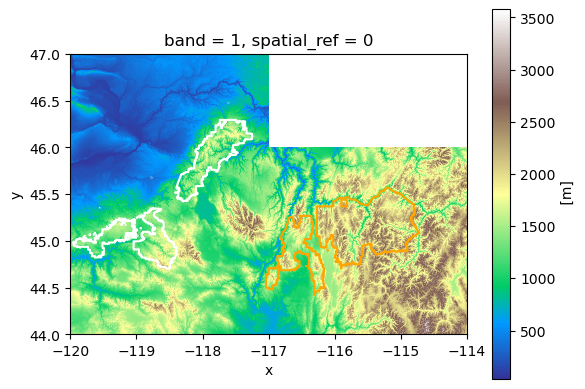

In [14]:
# Open each unzipped raster tile, put it into a list
# Then merge the tiles using rioxarray.merge
srtm_da_list = []

for gdf in gdfs: 
    gdfbounds = tuple((gdf.to_crs(4326).total_bounds))
    #print(bounds)
    xmin, ymin, xmax, ymax = gdfbounds
    gdfbounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
    for file in glob(srtm_pattern):
        tile_da = rxr.open_rasterio(file, mask_and_scale=True).squeeze()
        #tilebounds = tile_da.rio.bounds
        #tilegdf = gpd.GeoDataFrame([Polygon([[*tilebounds]])], index=[0], 
         #                                  crs=tile_da.rio.crs,
        #                           )
        #tilegdf = gpd.GeoDataFrame(index=[0], crs=tile_da.rio.crs,
        #                            geometry=[box([*tilebounds])]   
        #                           )
        #tile_geom = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        #bounds = (nfs2_gdf.to_crs(tile_da.rio.crs).total_bounds)
        #within_bounds = gdf.geometry.apply(lambda x: tilegdf.within(x)).any()
        #if within_bounds:
        #if gdf.within(tilegdf.loc[0, 'geometry']):
        try: 
            cropped_tile = tile_da.rio.clip_box(*gdfbounds_buffer)
            srtm_da_list.append(tile_da)
            srtm_das = merge_arrays(srtm_da_list)
        except: 
            pass

# Plot the merged tiles
srtm_das.plot(cmap='terrain')
uma_gdf.boundary.plot(ax=plt.gca(), color='white')
pay_gdf.boundary.plot(ax=plt.gca(), color='orange')

In [29]:
sites

{'gdf': [        ADMINFORES REGION FORESTNUMB FORESTORGC                FORESTNAME  \
  92  99061400010343     06         14       0614  Umatilla National Forest   
  
        GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
  92  1498094.353     0.69758  15.051197   
  
                                               geometry  
  92  MULTIPOLYGON (((-118.00972 45.61629, -118.0097...  ,
          ADMINFORES REGION FORESTNUMB FORESTORGC               FORESTNAME  \
  58  99041200010343     04         12       0412  Payette National Forest   
  
        GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
  58  2407296.569    1.113418  11.686712   
  
                                               geometry  
  58  MULTIPOLYGON (((-115.21399 45.56972, -115.2137...  ],
 'name': ['Umatilla', 'Payette']}

In [42]:
sites['gdf']

[        ADMINFORES REGION FORESTNUMB FORESTORGC               FORESTNAME  \
 58  99041200010343     04         12       0412  Payette National Forest   
 
       GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
 58  2407296.569    1.113418  11.686712   
 
                                              geometry  
 58  MULTIPOLYGON (((-115.21399 45.56972, -115.2137...  ,
         ADMINFORES REGION FORESTNUMB FORESTORGC                FORESTNAME  \
 92  99061400010343     06         14       0614  Umatilla National Forest   
 
       GIS_ACRES  SHAPE_AREA  SHAPE_LEN  \
 92  1498094.353     0.69758  15.051197   
 
                                              geometry  
 92  MULTIPOLYGON (((-118.00972 45.61629, -118.0097...  ]

In [49]:
# Add a buffer to the bounds of each gdf
srtm_da_crop_list = []

for gdf in [pay_gdf, uma_gdf]:
    bounds = tuple((gdf.to_crs(4326).total_bounds))
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
    #buff_bounds_dict[bounds_buffer] = bounds_buffer
    #buff_bounds_dict[site_name] = name
    srtm_da_crop = srtm_das.rio.clip_box(*bounds_buffer)
    srtm_da_crop_list.append(srtm_da_crop)

#buff_bounds_dict
srtm_da_crop_list

[<xarray.DataArray (y: 5933, x: 10153)> Size: 241MB
 array([[1405., 1409., 1409., ..., 2441., 2452., 2464.],
        [1403., 1406., 1408., ..., 2427., 2436., 2444.],
        [1400., 1404., 1407., ..., 2414., 2423., 2427.],
        ...,
        [ 824.,  826.,  826., ..., 2414., 2414., 2414.],
        [ 821.,  821.,  822., ..., 2405., 2406., 2405.],
        [ 819.,  819.,  821., ..., 2398., 2398., 2396.]], dtype=float32)
 Coordinates:
   * x            (x) float64 81kB -117.3 -117.3 -117.3 ... -114.5 -114.5 -114.5
   * y            (y) float64 47kB 45.82 45.82 45.82 45.82 ... 44.17 44.17 44.17
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     units:          m
     _FillValue:     nan,
 <xarray.DataArray (y: 8172, x: 10807)> Size: 353MB
 array([[ 366.,  363.,  359., ...,   nan,   nan,   nan],
        [ 357.,  354.,  352., ...,   nan,   nan,   nan],
        [ 348.,  346.,  342., ...,   nan,   nan,   nan],
        ...,
        [1775., 17

In [50]:
len(srtm_da_crop_list)

2

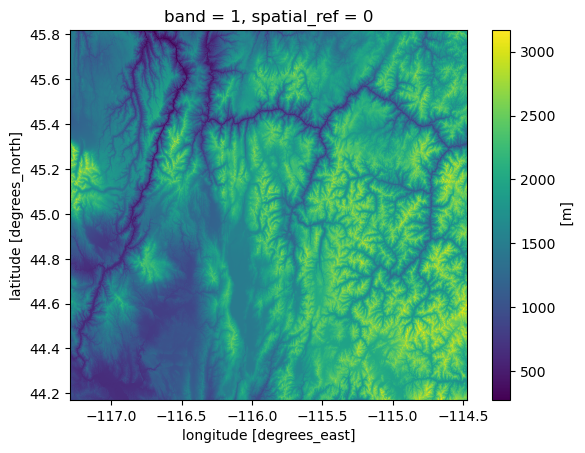

In [ ]:
srtm_da_crop_list[0].plot(cmap='terrain')
pay_gdf.boundary.plot(ax=plt.gca(), color='orange')

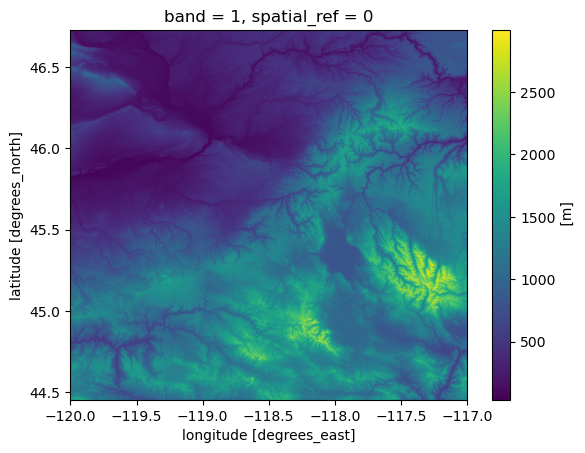

In [ ]:
srtm_da_crop_list[1].plot(cmap='terrain')
uma_gdf.boundary.plot(ax=plt.gca(), color='white')

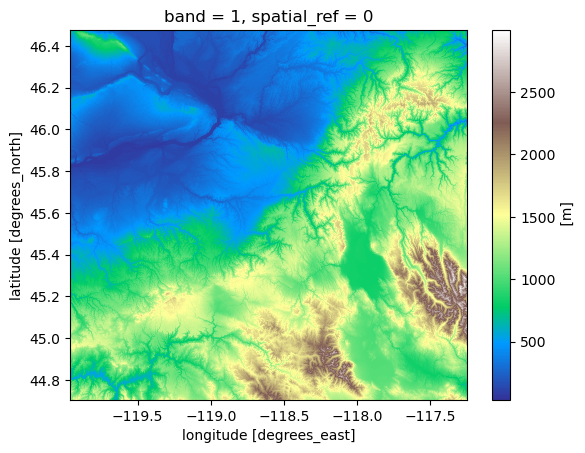

In [ ]:
# #split the forests and crop to their extents
# uma_bounds = (uma_gdf.to_crs(srtm_das.rio.crs).total_bounds)
# srtm_uma_crop = srtm_das.rio.clip_box(*uma_bounds)

# # srtm_uma_crop.plot(cmap='terrain')

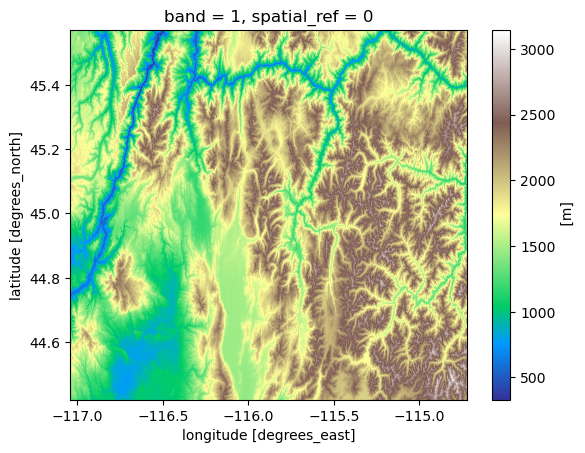

In [ ]:
# pay_bounds = (pay_gdf.to_crs(srtm_das.rio.crs).total_bounds)
# srtm_pay_crop = srtm_das.rio.clip_box(*pay_bounds)

# srtm_pay_crop.plot(cmap='terrain')

In [57]:
# Reproject the data to a WGS 84 projection for this region of North America
srtm_proj_pay = srtm_da_crop_list[0].rio.reproject(32611)
srtm_proj_uma = srtm_da_crop_list[1].rio.reproject(32611)

In [58]:
# calculate slope by site and put in a list
slope_das = []
for da in srtm_da_crop_list:
    slope_da = xrspatial.slope(da)
    slope_das.append(da)

slope_das

[<xarray.DataArray (y: 5933, x: 10153)> Size: 241MB
 array([[1405., 1409., 1409., ..., 2441., 2452., 2464.],
        [1403., 1406., 1408., ..., 2427., 2436., 2444.],
        [1400., 1404., 1407., ..., 2414., 2423., 2427.],
        ...,
        [ 824.,  826.,  826., ..., 2414., 2414., 2414.],
        [ 821.,  821.,  822., ..., 2405., 2406., 2405.],
        [ 819.,  819.,  821., ..., 2398., 2398., 2396.]], dtype=float32)
 Coordinates:
   * x            (x) float64 81kB -117.3 -117.3 -117.3 ... -114.5 -114.5 -114.5
   * y            (y) float64 47kB 45.82 45.82 45.82 45.82 ... 44.17 44.17 44.17
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Point
     units:          m
     _FillValue:     nan,
 <xarray.DataArray (y: 8172, x: 10807)> Size: 353MB
 array([[ 366.,  363.,  359., ...,   nan,   nan,   nan],
        [ 357.,  354.,  352., ...,   nan,   nan,   nan],
        [ 348.,  346.,  342., ...,   nan,   nan,   nan],
        ...,
        [1775., 17

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

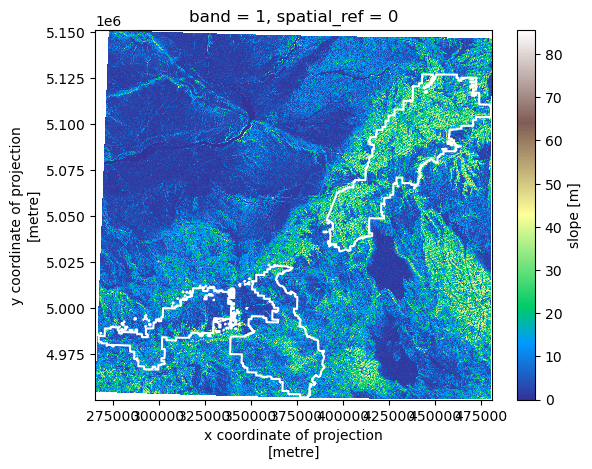

In [ ]:
# slope_da.plot(cmap='terrain')
# uma_gdf.to_crs(32611).boundary.plot(ax=plt.gca(), color='white')
# plt.show()

In [18]:
# POLARIS soil data
polaris_url_templ = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
    "/ph/mean/30_60/"
    "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

soil_dir = os.path.join(data_dir, 'polaris')
os.makedirs(soil_dir, exist_ok=True)

In [19]:
# Need the bounding box for the gdfs again
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    nfs2_gdf.total_bounds)
#range(floor(bounds_min_lon), ceil(bounds_max_lon))


In [20]:
# Create a list of all the Polaris layer URLs I will need to cover the spatial extent
polaris_url_list = []
# Identify and loop over all lat/lon combinations 
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        #print(min_lon, min_lat)
        polaris_url = polaris_url_templ.format(
            min_lat=min_lat, max_lat=min_lat+1, 
            min_lon=min_lon, max_lon=min_lon+1)
        polaris_url_list.append(polaris_url)
polaris_url_list 

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4445_lon-120-119.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4546_lon-120-119.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-120-119.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4445_lon-119-118.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4546_lon-119-118.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-119-118.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4445_lon-118-117.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4546_lon-118-117.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-118-117.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4445_lon-117-116.tif',
 'http://hydrology.cee.duke.edu/POLARIS/

In [21]:
# Now read in the tif files. Start with an empty list and then add each
# cropped tile of soil data into it
soil_da_list = []
nfs2bounds = nfs2_gdf.total_bounds
#gdfbounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
for file in polaris_url_list:
    soil_da = rxr.open_rasterio(file, mask_and_scale=True).squeeze()
    soil_crop = soil_da.rio.clip_box(*nfs2bounds)
    soil_da_list.append(soil_da)
    soil_das = merge_arrays(soil_da_list)
soil_das

<xarray.DataArray (y: 10800, x: 21600)> Size: 933MB
array([[      nan,       nan,       nan, ..., 6.0346055, 6.4399085,
        6.239113 ],
       [      nan,       nan,       nan, ..., 6.239113 , 6.5179963,
        6.5179963],
       [7.39167  ,       nan,       nan, ..., 6.312771 , 6.312771 ,
        6.3949785],
       ...,
       [8.212076 , 7.1325727, 7.131589 , ..., 7.2729216, 7.7166777,
        7.7166777],
       [7.1345215, 7.1345215, 7.132861 , ..., 7.384292 , 7.7166777,
        7.7166777],
       [7.149291 , 7.1337495, 7.1295824, ..., 7.51079  , 7.7166777,
        7.7166777]], dtype=float32)
Coordinates:
  * x            (x) float64 173kB -120.0 -120.0 -120.0 ... -114.0 -114.0 -114.0
  * y            (y) float64 86kB 47.0 47.0 47.0 47.0 ... 44.0 44.0 44.0 44.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan

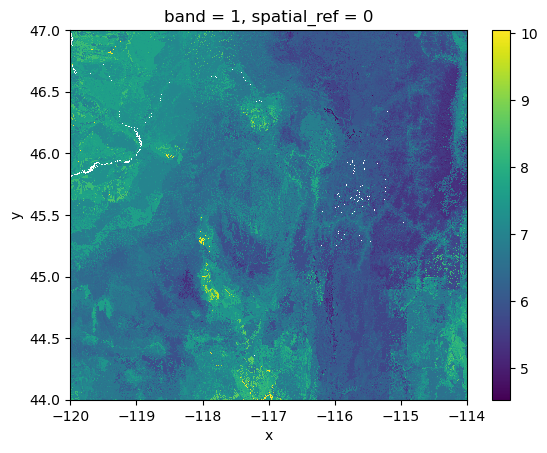

In [22]:
soil_das.plot()

In [ ]:
%store pay_gdf uma_gdf nfs2_gdf slope_das soil_das

Stored 'pay_gdf' (GeoDataFrame)
Stored 'uma_gdf' (GeoDataFrame)
Stored 'nfs2_gdf' (GeoDataFrame)
Stored 'srtm_das' (DataArray)
Stored 'soil_das' (DataArray)
